In [1]:
import numpy as np
import shapefile
import shapely.geometry
import scipy.sparse
from create_graph import create_graph
import geopandas as gpd
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload    
%autoreload 2

## SP Metropolis 2k Census Regions 

In [17]:
file = gpd.read_file("data/SP_Setores_2021/SP_Setores_2021.shp")
selected_row = 355030866000295
selected_row = file[file["CD_SETOR"].astype(int) == selected_row]
file["distance"] = file["geometry"].apply(lambda x: x.distance(selected_row.iloc[0]["geometry"]))
file = file.sort_values(by = "distance")
file = file[file.NM_MUN == "São Paulo"]
file = file.reset_index(drop = True)
file = file.head(2000)
file = file.drop(columns = ["distance"])

In [18]:
adj_matrix = create_graph(file)
adj_matrix = scipy.sparse.csr_matrix(adj_matrix)
scipy.sparse.save_npz("data/adj_matrix/SpCenterCensus2k.npz", adj_matrix)

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:01<00:00, 1605.62it/s]


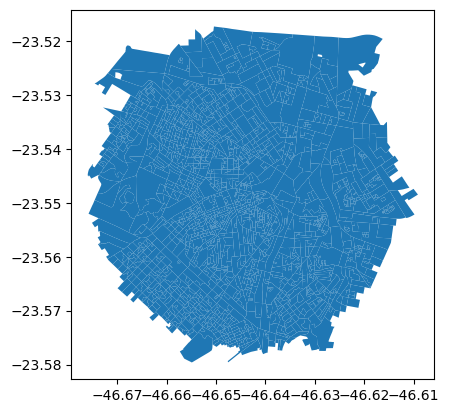

In [19]:
file.plot()
plt.show()

In [20]:
file = file[["geometry"]].reset_index()
file.columns = ["id_poly", "geometry"]
file.to_file("data/shapefiles/SpCenterCensus2k.geojson", driver='GeoJSON')

## SP Metropolis 5k Census Regions 

In [7]:
file = gpd.read_file("data/SP_Setores_2021/SP_Setores_2021.shp")
selected_row = 355030866000295
selected_row = file[file["CD_SETOR"].astype(int) == selected_row]
file["distance"] = file["geometry"].apply(lambda x: x.distance(selected_row.iloc[0]["geometry"]))
file = file.sort_values(by = "distance")
file = file[file.NM_MUN == "São Paulo"]
file = file.reset_index(drop = True)
file = file.head(5000)
file = file.drop(columns = ["distance"])

In [8]:
adj_matrix = create_graph(file)
adj_matrix = scipy.sparse.csr_matrix(adj_matrix)
scipy.sparse.save_npz("data/adj_matrix/SpCenterCensus5k.npz", adj_matrix)

100%|██████████| 5000/5000 [00:03<00:00, 1593.59it/s]


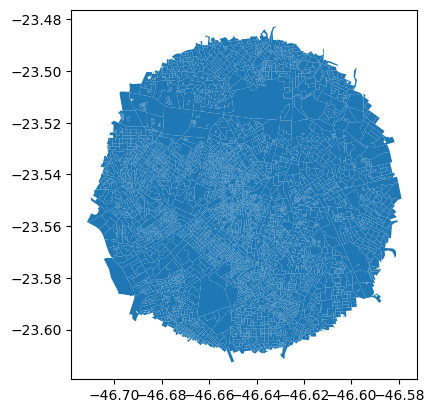

In [9]:
file.plot()
plt.show()

In [10]:
file = file[["geometry"]].reset_index()
file.columns = ["id_poly", "geometry"]
file.to_file("data/shapefiles/SpCenterCensus5k.geojson", driver='GeoJSON')

## Districts

In [11]:
file = gpd.read_file("data/LAYER_DISTRITO/DEINFO_DISTRITO.shp")
file = file.to_crs("EPSG:4326")

In [12]:
adj_matrix = create_graph(file)
np.save("data/adj_matrix/SpDistricts.npy", adj_matrix)

  0%|          | 0/96 [00:00<?, ?it/s]

100%|██████████| 96/96 [00:00<00:00, 258.56it/s]


In [13]:
file = file[["NOME_DIST", "geometry"]].reset_index()
file.columns = ["id_poly", "name", "geometry"]
file.to_file("data/shapefiles/SpDistricts.geojson", driver='GeoJSON')

## Grid

In [14]:
file = gpd.read_file("data/shapefiles/SpCenterCensus5k.shp")
# change to webmercator (south america)
file = file.to_crs("EPSG:3857")

# get x_min, x_max, y_min, y_max
x_min, y_min, x_max, y_max = file.total_bounds
x_center = (x_min + x_max)/2
x_range = (x_max - x_min)/2
y_center = (y_min + y_max)/2
y_range = (y_max - y_min)/2

# remove 10% of the distances in each direction
x_min = x_center - 4/5 * x_range
x_max = x_center + 4/5 * x_range
y_min = y_center - 4/5 * y_range
y_max = y_center + 4/5 * y_range
x_range = (x_max - x_min)
y_range = (y_max - y_min)

x_steps = 50
y_steps = 50

new_geometries = []

for i in range(x_steps):
    for j in range(y_steps):
        bbox = [
            x_min + i/x_steps * x_range,
            y_min + j/y_steps * y_range,
            x_min + (i+1)/x_steps * x_range,
            y_min + (j+1)/y_steps * y_range
        ]
        new_geometries.append(shapely.geometry.box(*bbox))

In [15]:
file = gpd.GeoDataFrame(geometry = new_geometries, crs="EPSG:3857").reset_index()
file.columns = ["id_poly", "geometry"]
file = file.to_crs("EPSG:4326")
file.to_file("data/shapefiles/SpGrid.geojson", driver='GeoJSON')

In [16]:
adj_matrix = create_graph(file)
adj_matrix = scipy.sparse.csr_matrix(adj_matrix)
scipy.sparse.save_npz("data/adj_matrix/SpGrid.npz", adj_matrix)

  0%|          | 0/2500 [00:00<?, ?it/s]

100%|██████████| 2500/2500 [00:01<00:00, 2395.11it/s]


## NY Blocks

In [15]:
file = gpd.read_file("data/ny_blocks/cb_2018_36_bg_500k.shp")
file = file[file.COUNTYFP == "061"]
file = file.to_crs("EPSG:4326").reset_index(drop = True)

In [17]:
adj_matrix = create_graph(file)
np.save("data/adj_matrix/NYBlocks.npy", adj_matrix)

  0%|          | 0/1168 [00:00<?, ?it/s]

100%|██████████| 1168/1168 [00:00<00:00, 1811.99it/s]


In [22]:
file = file[["geometry"]].reset_index()
file.columns = ["id_poly", "geometry"]
file.to_file("data/shapefiles/NYBlocks.geojson", driver='GeoJSON')

## BLA Cities

In [2]:
file = gpd.read_file("data/municipalities_legal_amazon/municipalities_legal_amazon.shp", encoding = "utf-8")
file = file.to_crs("EPSG:4326")
file = file[["nm_municip", "geometry"]]
file = file.reset_index()
file.columns = ["id_poly", "name", "geometry"]

In [31]:
adj_matrix = create_graph(file)
np.save("data/adj_matrix/BLACities.npy", adj_matrix)

100%|██████████| 773/773 [00:07<00:00, 105.53it/s]


In [34]:
file["geometry"] = file.simplify(0.01)
file.to_file("data/shapefiles/BLACities.geojson", driver='GeoJSON')